In [4]:
import re
import numpy as np
import pandas as pd
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

# import self-defined class Rule miner for preprocessing data, mining, and selecting useful association rules.
from hold_behaviour_mining.rule_miner import Rule_miner

In [5]:
# import raw data
test_2 = pd.read_csv('D:\\Suite_Data\\from_py\\event_list_June22.csv', 
                    parse_dates=['startTimestamp', 'endtTime'])

test_2

,Identifier,startTimestamp,endtTime,coolHoldTemp,heatHoldTemp,Setpoint_before_C,Setpoint_before_H,Setpoint_after_C,Setpoint_after_H,Mode,Connect_before,Connect_after
0,311000307137,2018-06-01 00:48:17,2018-06-01 00:51:20,23.0,23.0,22.000000,22.000000,24.0,24.0,cool,Event,Event
1,311000307137,2018-06-01 00:51:07,2018-06-01 09:46:21,24.0,24.0,23.000000,23.000000,23.0,23.0,cool,Event,Event
2,311000307137,2018-06-01 09:50:15,2018-07-06 00:04:56,23.0,23.0,24.000000,24.000000,24.0,24.0,cool,Event,Event
3,311000307137,2018-07-27 17:25:48,2018-07-27 23:34:44,23.0,23.0,25.611111,22.833333,23.5,23.5,cool,Schedule,Event
4,311000307137,2018-07-27 23:34:52,2018-07-31 23:35:06,23.5,23.5,23.000000,23.000000,24.0,24.0,cool,Event,Event
...,...,...,...,...,...,...,...,...,...,...,...,...
13586,315604722367,2018-11-10 03:27:50,2018-11-10 07:40:33,23.5,23.5,23.000000,23.000000,23.5,22.5,heat,Event,Schedule
13587,315604722367,2018-11-12 07:09:20,2018-11-18 02:41:08,22.0,22.0,23.000000,22.500000,22.5,22.5,heat,Schedule,Event
13588,315604722367,2018-11-18 02:41:08,2018-11-19 20:46:18,22.5,22.5,22.000000,22.000000,22.5,22.5,heat,Event,Event
13589,315604722367,2018-11-19 20:48:14,2018-11-20 22:36:32,22.5,22.5,22.500000,22.500000,23.5,23.0,heat,Event,Schedule


# Distributin of No. of Holds

- Only select users with more than 50 holds they made on thermostats.
- Most of the users were selected according to the histogram below.

In [6]:
user_count = test_2.groupby('Identifier')['startTimestamp'].count()

user_count[user_count >= 50].shape[0]/user_count.shape[0]

0.6911764705882353

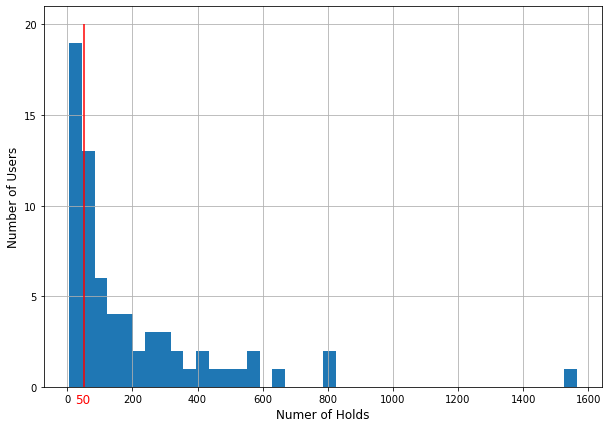

In [98]:
ax = user_count.hist(figsize=(10, 7), bins=40)
ax.set_xlabel('Numer of Holds', fontsize=12)
ax.set_ylabel('Number of Users', fontsize=12)

ax.set_yticks(range(0, 21, 5))

ax.vlines(50, 0, 20, 'r')
ax.annotate('50', (50, 0), (25, -0.9), c='r', fontsize=12)
plt.show()

# Association Rule Mining

- Use the costum class Rule_miner to discover association rules.
- The class is capable of catogorizing the variables and discover association rules based on specified support and confidence.
- The class is also capable of filtering out unuseful rules and output a relatively concise rule set. 

In [93]:
# implement the Rule_miner for each user and save the results in a dictionary
label_dict = {}
rules_total = []
for user_id  in test_2['Identifier'].unique():

    df_sub = test_2[test_2['Identifier'] == user_id].copy()
    
    arm = Rule_miner(df_sub)
    try:
        arm.generate_rules()
    except:
        print('Failed ids: {}'.format(user_id))
        print('Sample size: {}'.format(arm.feature_set.shape[0]))
        
        continue
    
    df_rule = arm.rules.copy()
    df_rule.index = range(len(df_rule))
    
    index = pd.MultiIndex.from_product([[user_id], df_rule.index], names=['Identifier', 'No.'])
    
    df_rule = pd.DataFrame(df_rule.values, columns=df_rule.columns, index=index)
    
    rules_total.append(df_rule)
    
    label_col = {}
    for col in ['startTimestamp', 'endtTime', 'length', 'coolHoldTemp', 'heatHoldTemp','Mode', 
                'Connect_before', 'Connect_after', 'Heating_Setback', 'Cooling_Setback', 'Year_Month']:
        
        labels_per_col = arm.events_feature[col].unique()
        label_col.update({col: labels_per_col})
    
    label_dict.update({user_id: label_col})
    
rules_total = pd.concat(rules_total)

Failed ids: 311008234437
Sample size: 25
Failed ids: 311016513537
Sample size: 25
Failed ids: 311019945850
Sample size: 10
Failed ids: 311027954879
Sample size: 11
Failed ids: 311028211557
Sample size: 46
Failed ids: 311032621539
Sample size: 42
Failed ids: 311036131368
Sample size: 6
Failed ids: 311036599847
Sample size: 8
Failed ids: 311039740738
Sample size: 47
Failed ids: 311044508244
Sample size: 22
Failed ids: 311050268019
Sample size: 43
Failed ids: 311056200459
Sample size: 32
Failed ids: 311056208181
Sample size: 31
Failed ids: 311057474888
Sample size: 15
Failed ids: 311058553889
Sample size: 17
Failed ids: 311063955030
Sample size: 43
Failed ids: 311063956237
Sample size: 12
Failed ids: 311080237263
Sample size: 42
Failed ids: 311090042970
Sample size: 18
Failed ids: 311090593230
Sample size: 32
Failed ids: 315604722367
Sample size: 27


In [8]:
# organize the rules set
rules_total = rules_total.reset_index('Identifier')
rules_total.index = range(len(rules_total))

In [10]:
print('Total number of rules: {}'.format(len(rules_total)))
rules_total.head()

Total number of rules: 2565


,Identifier,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,311000307137,(Mode&cool),(Connect_after&Event),0.396825,0.873016,0.333333,0.84,0.962182
1,311000307137,(Mode&heat),(Connect_after&Event),0.603175,0.873016,0.539683,0.894737,1.02488
2,311000307137,(Mode&cool),(Connect_before&Event),0.396825,0.857143,0.333333,0.84,0.98
3,311000307137,(Mode&heat),(Connect_before&Event),0.603175,0.857143,0.52381,0.868421,1.013158
4,311000307137,(Mode&cool),(coolHoldTemp&22-24),0.396825,0.777778,0.333333,0.84,1.08


## Addictional Rule Selection

- This part is also for rule selection on top of the rule selection functions embedded in the Rule_miner class.
- These rules can also be embedded in the Rule_miner in the future if they are proofed a generalized method for other datasets.

In [11]:
# year_month not in consequent

row_taker=[]
for index, row in rules_total.iterrows():
    
    cons = [re.split('&', a)[0] for a in row['consequents']]
    l_m = any([re.search('Year_Month', a) for a in cons])
    
    if l_m:
        
        continue
        
    else:
        row_taker.append(row)

rules_total = pd.DataFrame(row_taker)

# remove setback and set point

row_taker=[]
for index, row in rules_total.iterrows():
    
    ante = [re.split('&', a)[0] for a in row['antecedents']]
    cons = [re.split('&', a)[0] for a in row['consequents']]
    tot = ante + cons
    
    stp = any([re.search('HoldTemp', a) for a in tot])
    sbk = any([re.search('_Setback', a) for a in tot])
    
    if stp & sbk:
        continue
    else:
        row_taker.append(row)

rules_total = pd.DataFrame(row_taker)

# remove start\end time and length
row_taker=[]
for index, row in rules_total.iterrows():
    
    ante = [re.split('&', a)[0] for a in row['antecedents']]
    cons = [re.split('&', a)[0] for a in row['consequents']]
    tot = ante + cons
    
    st = any([re.search('startTimestamp', a) for a in tot])
    et = any([re.search('endtTime', a) for a in tot])    
    length = any([re.search('length', a) for a in tot])
        
    if st & et & length:
            
        continue

    else:
        row_taker.append(row)

rules_total = pd.DataFrame(row_taker)

# remove non logical antecedents: Connect_after, endtTime

row_taker=[]

for index, row in rules_total.iterrows():
    
    ante = [re.split('&', a)[0] for a in row['antecedents']]
    cons = [re.split('&', a)[0] for a in row['consequents']]
    
    if any([re.search('endtTime', a) for a in ante]):
        
        if all([re.search('Connect_after', a) for a in cons]):
            row_taker.append(row)
        else:
            continue
    
    elif any([re.search('Connect_after', a) for a in ante]):
    
        if all([re.search('endtTime', a) for a in cons]):
            row_taker.append(row)
        
        else:
            continue
    
    else:
        row_taker.append(row)

rules_total = pd.DataFrame(row_taker)

In [13]:
# Number of rules is effecitive reduced
print('Total number of rules: {}'.format(len(rules_total)))
rules_total.head()

Total number of rules: 1273


,Identifier,antecedents,consequents,antecedent support,consequent support,support,confidence,lift
0,311000307137,(Mode&cool),(Connect_after&Event),0.396825,0.873016,0.333333,0.840000,0.962182
1,311000307137,(Mode&heat),(Connect_after&Event),0.603175,0.873016,0.539683,0.894737,1.024880
2,311000307137,(Mode&cool),(Connect_before&Event),0.396825,0.857143,0.333333,0.840000,0.980000
3,311000307137,(Mode&heat),(Connect_before&Event),0.603175,0.857143,0.523810,0.868421,1.013158
4,311000307137,(Mode&cool),(coolHoldTemp&22-24),0.396825,0.777778,0.333333,0.840000,1.080000


# Collective Description

- Group the rule by their variables as rule classes.


In [14]:
def ante_cons(row):
    
    '''
    Extract variable names from both antecedent and consequent.
    '''
    
    ante = [re.split('&', c)[0] for c in row['antecedents']]
    ante.append('ante') # add ante. indicator
    ante = frozenset(ante)
    
    cons = [re.split('&', c)[0] for c in row['consequents']]
    cons = frozenset(cons)
    
    # add them to a frozenset
    total = frozenset({ante, cons})
    
    return total

In [38]:
rule_class = rules_total.apply(ante_cons, axis=1)

rule_class = pd.DataFrame(rule_class, columns=['Name'])

rule_class

,Name
0,"((Mode, ante), (Connect_after))"
1,"((Mode, ante), (Connect_after))"
2,"((Connect_before), (Mode, ante))"
3,"((Connect_before), (Mode, ante))"
4,"((coolHoldTemp), (Mode, ante))"
...,...
2560,"((Mode, ante, length), (Connect_after))"
2561,"((Connect_before), (Mode, Cooling_Setback, ante))"
2562,"((Connect_before), (Year_Month, Mode, ante))"
2563,"((Connect_before), (Year_Month, Mode, ante))"


In [39]:
# give each rule class a number in 'Num' column
rule_num = pd.DataFrame(rule_class['Name'].unique(), columns=['Name'])

rule_num['Num'] = range(len(rule_num))

rule_num

,Name,Num
0,"((Mode, ante), (Connect_after))",0
1,"((Connect_before), (Mode, ante))",1
2,"((coolHoldTemp), (Mode, ante))",2
3,"((Mode, ante, length), (heatHoldTemp))",3
4,"((coolHoldTemp), (Mode, startTimestamp, ante))",4
...,...,...
229,"((Cooling_Setback), (length, startTimestamp, M...",229
230,"((length, Year_Month, Mode, ante, Connect_befo...",230
231,"((endtTime), (startTimestamp, coolHoldTemp, Ye...",231
232,"((length), (startTimestamp, coolHoldTemp, Year...",232


In [40]:
# merge the rule class numbers on the rule set
rule_index = rule_class.index
rule_class = pd.merge(rule_class, rule_num, how='left', on='Name')
rule_class.index = rule_index
rule_class

,Name,Num
0,"((Mode, ante), (Connect_after))",0
1,"((Mode, ante), (Connect_after))",0
2,"((Connect_before), (Mode, ante))",1
3,"((Connect_before), (Mode, ante))",1
4,"((coolHoldTemp), (Mode, ante))",2
...,...,...
2560,"((Mode, ante, length), (Connect_after))",13
2561,"((Connect_before), (Mode, Cooling_Setback, ante))",14
2562,"((Connect_before), (Year_Month, Mode, ante))",17
2563,"((Connect_before), (Year_Month, Mode, ante))",17


# Rule class

- Find top 3 common rule classes among users.

In [41]:
# count the num of users per rule class
rules_all = rules_total.join(rule_class)

user_num = rules_all.groupby('Num')['Identifier'].unique()
user_num = user_num.apply(lambda x: len(x))

user_num = user_num.sort_values(ascending=False)

Text(0, 0.5, 'Number of Rule Classes')

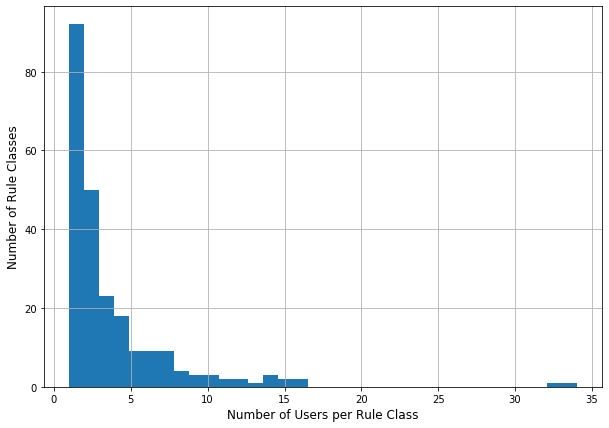

In [42]:
# visualize the results
ax = user_num.hist(bins=34, figsize=(10, 7))
ax.set_xlabel('Number of Users per Rule Class', fontsize=12)
ax.set_ylabel('Number of Rule Classes', fontsize=12)

In [43]:
# investigate top 3 rule classes
class_num = user_num.nlargest(3)

class_num

Num
1    34
0    33
9    16
Name: Identifier, dtype: int64

In [45]:
# invetigate values within each rule class

# Rule 1
target_index = rule_class[rule_class['Num'] == class_num.index[0]].index
target_rules = rules_total[['antecedents', 'consequents', 'support', 'confidence']].reindex(index=target_index)

target_rules['count']=1

print('Num of rule in rule class', target_rules.shape[0])
target_count = target_rules.groupby(['antecedents', 'consequents']).count()
target_count = target_count.div(target_count['count'].sum()/100)
target_count = target_count.round(1)
target_count

Num of rule in rule class 53


support  confidence  count
antecedents consequents                                          
(Mode&cool) (Connect_before&Event)        45.3        45.3   45.3
            (Connect_before&Schedule)      9.4         9.4    9.4
(Mode&heat) (Connect_before&Event)        35.8        35.8   35.8
            (Connect_before&Schedule)      9.4         9.4    9.4

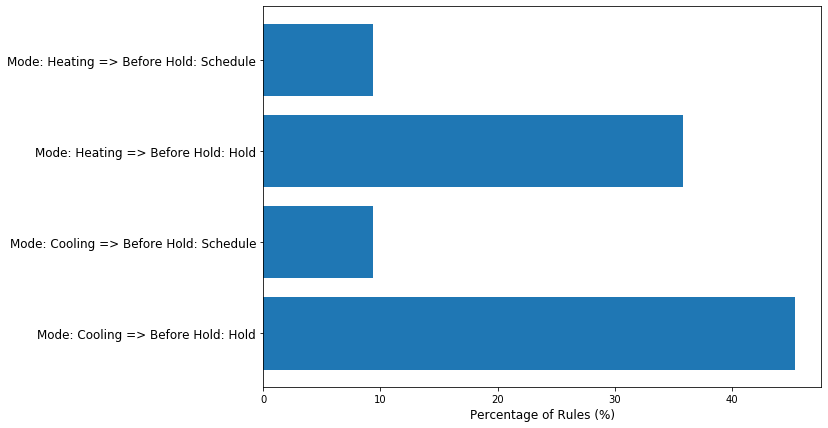

In [46]:
# visualize
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(range(len(target_count)), target_count['count'])

labels = ('Mode: Cooling => Before Hold: Hold', 'Mode: Cooling => Before Hold: Schedule',
           'Mode: Heating => Before Hold: Hold', 'Mode: Heating => Before Hold: Schedule')
ax.set_yticks(range(len(target_count)))
ax.set_yticklabels(labels, fontsize=12)

#ax.bar_labels(target_count['count'])

ax.set_xlabel('Percentage of Rules (%)', fontsize=12)

plt.show()

In [47]:
# user overlaps
user_overlap = target_rules.join(rules_total['Identifier'])

user_overlap[user_overlap.duplicated('Identifier', keep=False)]

,antecedents,consequents,support,confidence,count,Identifier
2,(Mode&cool),(Connect_before&Event),0.333333,0.840000,1,311000307137
3,(Mode&heat),(Connect_before&Event),0.523810,0.868421,1,311000307137
9,(Mode&cool),(Connect_before&Event),0.547576,0.983871,1,311003649883
10,(Mode&heat),(Connect_before&Event),0.441652,0.995951,1,311003649883
219,(Mode&cool),(Connect_before&Event),0.559322,0.825000,1,311018047948
220,(Mode&heat),(Connect_before&Event),0.271186,0.842105,1,311018047948
230,(Mode&cool),(Connect_before&Event),0.103321,0.949153,1,311020012484
231,(Mode&heat),(Connect_before&Event),0.880074,0.987578,1,311020012484
680,(Mode&cool),(Connect_before&Schedule),0.461538,0.888889,1,311025795445
681,(Mode&heat),(Connect_before&Schedule),0.480769,1.000000,1,311025795445


In [48]:
# Rule class 2

target_index = rule_class[rule_class['Num'] == class_num.index[1]].index
target_rules = rules_total[['antecedents', 'consequents', 'support', 'confidence']].reindex(index=target_index)

target_rules['count']=1

print('Num of rule in rule class', target_rules.shape[0])
target_count = target_rules.groupby(['antecedents', 'consequents']).count()
target_count = target_count.div(target_count['count'].sum()/100)
target_count = target_count.round(1)
target_count

Num of rule in rule class 52


support  confidence  count
antecedents consequents                                         
(Mode&cool) (Connect_after&Event)        42.3        42.3   42.3
            (Connect_after&Schedule)     11.5        11.5   11.5
(Mode&heat) (Connect_after&Event)        36.5        36.5   36.5
            (Connect_after&Schedule)      9.6         9.6    9.6

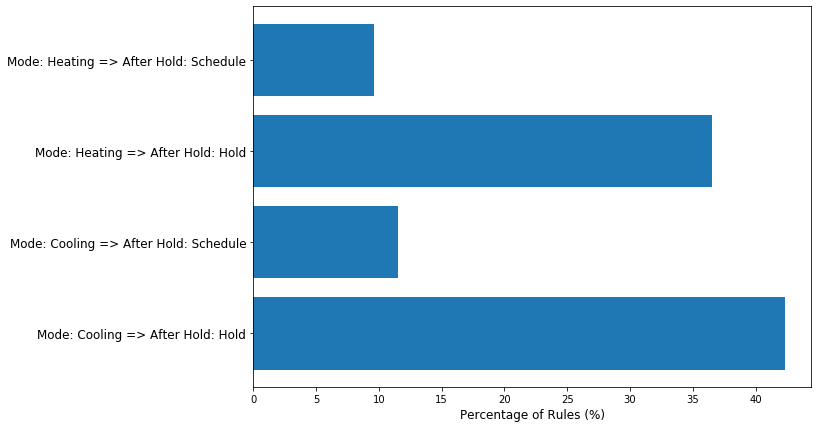

In [51]:
# visualize
# visualize
fig, ax = plt.subplots(figsize=(10, 7))
ax.barh(range(len(target_count)), target_count['count'])

labels = ('Mode: Cooling => After Hold: Hold', 'Mode: Cooling => After Hold: Schedule',
           'Mode: Heating => After Hold: Hold', 'Mode: Heating => After Hold: Schedule')
ax.set_yticks(range(len(target_count)))
ax.set_yticklabels(labels, fontsize=12)

#ax.bar_labels(target_count['count'])

ax.set_xlabel('Percentage of Rules (%)', fontsize=12)

plt.show()

In [52]:
# user overlaps
user_overlap = target_rules.join(rules_total['Identifier'])

user_overlap

,antecedents,consequents,support,confidence,count,Identifier
0,(Mode&cool),(Connect_after&Event),0.333333,0.840000,1,311000307137
1,(Mode&heat),(Connect_after&Event),0.539683,0.894737,1,311000307137
7,(Mode&cool),(Connect_after&Event),0.549372,0.987097,1,311003649883
8,(Mode&heat),(Connect_after&Event),0.441652,0.995951,1,311003649883
45,(Mode&cool),(Connect_after&Event),1.000000,1.000000,1,311006254842
164,(Mode&heat),(Connect_after&Schedule),0.194915,0.920000,1,311010489559
178,(Mode&cool),(Connect_after&Event),0.541528,0.942197,1,311013728929
217,(Mode&cool),(Connect_after&Event),0.610169,0.900000,1,311018047948
218,(Mode&heat),(Connect_after&Event),0.271186,0.842105,1,311018047948
228,(Mode&cool),(Connect_after&Event),0.097786,0.898305,1,311020012484


In [54]:
# Rule class 3

target_index = rule_class[rule_class['Num'] == class_num.index[2]].index
target_rules = rules_total[['antecedents', 'consequents', 'support', 'confidence']].reindex(index=target_index)

target_rules['count']=1

print('Num of rule in rule class', target_rules.shape[0])
target_count = target_rules.groupby(['antecedents', 'consequents']).count()
#target_count = target_count.div(target_count['count'].sum()/100)
#target_count = target_count.round(1)
print('Num of unique rules in rule class', target_count.shape[0])
target_count

Num of rule in rule class 48
Num of unique rules in rule class 27


support  \
antecedents                       consequents                         
(Mode&cool, endtTime&6:00-8:00)   (Connect_after&Schedule)        2   
(Mode&heat, endtTime&6:00-8:00)   (Connect_after&Event)           3   
(Mode&heat, endtTime&22:00-24:00) (Connect_after&Schedule)        3   
                                  (Connect_after&Event)           1   
(Mode&cool, endtTime&0:00-6:00)   (Connect_after&Schedule)        6   
                                  (Connect_after&Event)           1   
(Mode&cool, endtTime&8:00-10:00)  (Connect_after&Event)           1   
(endtTime&18:00-20:00, Mode&cool) (Connect_after&Event)           1   
(endtTime&22:00-24:00, Mode&cool) (Connect_after&Schedule)        3   
(Mode&cool, endtTime&20:00-22:00) (Connect_after&Schedule)        1   
(Mode&heat, endtTime&16:00-18:00) (Connect_after&Event)           2   
(Mode&heat, endtTime&14:00-16:00) (Connect_after&Event)           2   
(Mode&heat, endtTime&12:00-14:00) (Connect_after&Event)           2   
(Mode&cool, endtTime&16:00-18:00) (Connect_after&Event)           1   
(Mode&cool, endtTime&14:00-16:00) (Connect_after&Event)           1   
(endtTime&12:00-14:00, Mode&cool) (Connect_after&Event)           1   
(endtTime&10:00-12:00, Mode&cool) (Connect_after&Event)           1   
(endtTime&10:00-12:00, Mode&heat) (Connect_after&Schedule)        1   
                                  (Connect_after&Event)           4   
(Mode&heat, endtTime&20:00-22:00) (Connect_after&Schedule)        1   
                                  (Connect_after&Event)           2   
(Mode&heat, endtTime&18:00-20:00) (Connect_after&Schedule)        1   
                                  (Connect_after&Event)           2   
(Mode&heat, endtTime&8:00-10:00)  (Connect_after&Schedule)        1   
                                  (Connect_after&Event)           1   
(Mode&heat, endtTime&0:00-6:00)   (Connect_after&Schedule)        2   
                                  (Connect_after&Event)           1   

                                                            confidence  count  
antecedents                       consequents                                  
(Mode&cool, endtTime&6:00-8:00)   (Connect_after&Schedule)           2      2  
(Mode&heat, endtTime&6:00-8:00)   (Connect_after&Event)              3      3  
(Mode&heat, endtTime&22:00-24:00) (Connect_after&Schedule)           3      3  
                                  (Connect_after&Event)              1      1  
(Mode&cool, endtTime&0:00-6:00)   (Connect_after&Schedule)           6      6  
                                  (Connect_after&Event)              1      1  
(Mode&cool, endtTime&8:00-10:00)  (Connect_after&Event)              1      1  
(endtTime&18:00-20:00, Mode&cool) (Connect_after&Event)              1      1  
(endtTime&22:00-24:00, Mode&cool) (Connect_after&Schedule)           3      3  
(Mode&cool, endtTime&20:00-22:00) (Connect_after&Schedule)           1      1  
(Mode&heat, endtTime&16:00-18:00) (Connect_after&Event)              2      2  
(Mode&heat, endtTime&14:00-16:00) (Connect_after&Event)              2      2  
(Mode&heat, endtTime&12:00-14:00) (Connect_after&Event)              2      2  
(Mode&cool, endtTime&16:00-18:00) (Connect_after&Event)              1      1  
(Mode&cool, endtTime&14:00-16:00) (Connect_after&Event)              1      1  
(endtTime&12:00-14:00, Mode&cool) (Connect_after&Event)              1      1  
(endtTime&10:00-12:00, Mode&cool) (Connect_after&Event)              1      1  
(endtTime&10:00-12:00, Mode&heat) (Connect_after&Schedule)           1      1  
                                  (Connect_after&Event)              4      4  
(Mode&heat, endtTime&20:00-22:00) (Connect_after&Schedule)           1      1  
                                  (Connect_after&Event)              2      2  
(Mode&heat, endtTime&18:00-20:00) (Connect_after&Schedule)           1      1  
                                  (Connect_after&Event)              2      2  


In [55]:
# user overlaps
user_overlap = target_rules.join(rules_total['Identifier'])

user_overlap[user_overlap.duplicated('Identifier')]

,antecedents,consequents,support,confidence,count,Identifier
62,"(Mode&heat, endtTime&18:00-20:00)",(Connect_after&Schedule),0.073579,0.846154,1,311009954761
63,"(Mode&heat, endtTime&20:00-22:00)",(Connect_after&Schedule),0.053512,0.888889,1,311009954761
273,"(endtTime&12:00-14:00, Mode&cool)",(Connect_after&Event),0.023227,0.904762,1,311022813654
274,"(Mode&cool, endtTime&14:00-16:00)",(Connect_after&Event),0.045232,0.973684,1,311022813654
275,"(Mode&cool, endtTime&16:00-18:00)",(Connect_after&Event),0.074572,0.897059,1,311022813654
279,"(endtTime&10:00-12:00, Mode&heat)",(Connect_after&Event),0.013447,0.916667,1,311022813654
280,"(Mode&heat, endtTime&12:00-14:00)",(Connect_after&Event),0.029340,0.888889,1,311022813654
281,"(Mode&heat, endtTime&14:00-16:00)",(Connect_after&Event),0.036675,0.882353,1,311022813654
282,"(Mode&heat, endtTime&16:00-18:00)",(Connect_after&Event),0.088020,0.911392,1,311022813654
283,"(Mode&heat, endtTime&18:00-20:00)",(Connect_after&Event),0.045232,0.804348,1,311022813654


In [56]:
# heat map
heat_map=[]

cons = target_rules['consequents'].unique()

for c in cons:
    
    taker = []

    for a in target_rules[target_rules['consequents']== c]['antecedents']:
        
        # get end time interval
        condition = [re.split('&', et)[1] for et in a if re.search('endtTime', et)]
        if len(condition) != 1:
            raise ValueError('More than 1 end time')
        # turn interval into ints
        condition = condition[0]
        
        st = re.split('-', condition)[0]
        et = re.split('-', condition)[1]
        
        st = re.split(':', st)[0]
        et = re.split(':', et)[0]
        
        st = int(st)
        et = int(et)
        
        slot = list(range(st, et))
        
        taker = taker + slot
        
    name = re.split('&', list(c)[0])[1]
    taker = pd.Series(taker, name=name)
    
    heat_map.append(taker)
        

In [57]:
heat_map_f = []
for h in heat_map:
    
    h = h.groupby(h).count()
    
    heat_map_f.append(h)

In [58]:
heat_map = pd.DataFrame(heat_map_f).fillna(0)

heat_map = heat_map.rename(index={'Event':'Hold'})

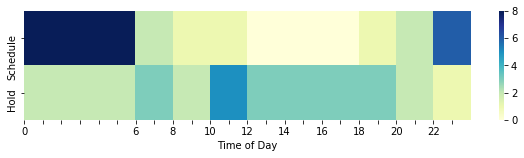

In [59]:
plt.figure(figsize=(10, 2))
sns.heatmap(heat_map, cmap='YlGnBu')

label = [0, '', '', '', '', '', 6, '', 8, '', 10, '', 12, '', 14, '', 16, '', 18, '', 20, '', 22, '', 24]
plt.xticks(np.arange(0, 24), labels=label)
plt.xlabel('Time of Day')
plt.show()

# Inviestigate by Individual Users

- Inviestigate all the association rules from three selected users.
- Selected user IDs: 311057102114, 311020012484, 311033070260

In [64]:
# visualize count of rules and rule classes by users

rules_total = rules_total.join(rule_class)

class_count = rules_total.groupby('Identifier')['Num'].unique()
class_count = class_count.apply(lambda x: len(x))

rules_count = rules_all.groupby('Identifier')['Num'].count()

counts = pd.DataFrame([rules_count, class_count]).T
counts.columns=['r_count', 'c_count']
counts = pd.DataFrame([rules_count, class_count]).T
counts.columns=['r_count', 'c_count']

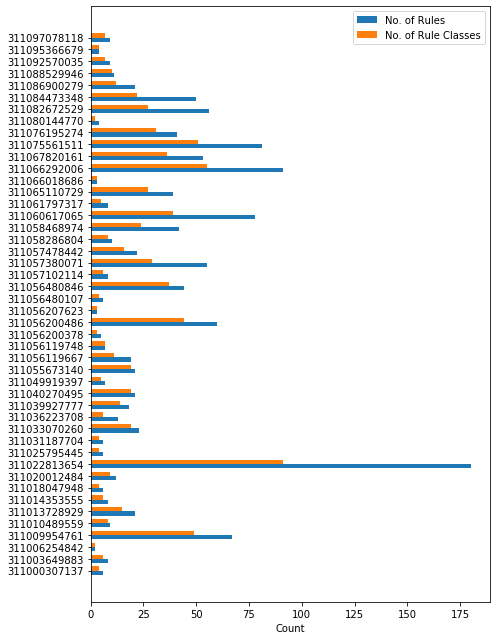

In [65]:
label = counts.index
r_count = counts['r_count']
c_count = counts['c_count']

x = np.arange(len(label))
width = 0.35

fig, ax = plt.subplots(figsize=(7, 9))
rects1 = ax.barh(x-width/2, r_count, width, label='No. of Rules')
rects2 = ax.barh(x+width/2, c_count, width, label='No. of Rule Classes')

# add texts
ax.set_xlabel('Count')
ax.set_yticks(x)
ax.set_yticklabels(label)
ax.legend()

#ax.vlines(20, x.min(), x.max(), 'b')

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

- Rules from ser 2 and 3 can be extracted by similar scripts
- In order to interpret rules, it is desirable to interpret rule classes first
- Detaild anaysis can refer to my master thesis.

In [66]:
# user 1
user_1 = rules_total[rules_total['Identifier'] == 311020012484].copy()
user_1.index = range(1, len(user_1)+1)
user_1

,Identifier,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,Name,Num
1,311020012484,(Mode&cool),(Connect_after&Event),0.108856,0.976015,0.097786,0.898305,0.920381,"((Mode, ante), (Connect_after))",0
2,311020012484,(Mode&heat),(Connect_after&Event),0.891144,0.976015,0.878229,0.985507,1.009726,"((Mode, ante), (Connect_after))",0
3,311020012484,(Mode&cool),(Connect_before&Event),0.108856,0.983395,0.103321,0.949153,0.965180,"((Connect_before), (Mode, ante))",1
4,311020012484,(Mode&heat),(Connect_before&Event),0.891144,0.983395,0.880074,0.987578,1.004253,"((Connect_before), (Mode, ante))",1
5,311020012484,"(Heating_Setback&2-3, Mode&heat, startTimestam...",(length&<=2_Hours),0.018450,0.343173,0.018450,1.000000,2.913978,"((startTimestamp, Mode, Heating_Setback, ante)...",63
6,311020012484,"(Year_Month&2019-02, Mode&heat, length&<=2_Hours)",(heatHoldTemp&24-26),0.020295,0.431734,0.018450,0.909091,2.105672,"((Year_Month, Mode, ante, length), (heatHoldTe...",64
7,311020012484,"(length&6-12_Hours, Mode&heat, Year_Month&2019...",(heatHoldTemp&22-24),0.047970,0.464945,0.040590,0.846154,1.819902,"((Year_Month, Mode, ante, length), (heatHoldTe...",64
8,311020012484,"(heatHoldTemp&24-26, Year_Month&2019-04, Mode&...",(length&<=2_Hours),0.029520,0.343173,0.025830,0.875000,2.549731,"((length), (Year_Month, Mode, heatHoldTemp, an...",65
9,311020012484,"(startTimestamp&20:00-22:00, Mode&heat, heatHo...",(length&6-12_Hours),0.020295,0.238007,0.018450,0.909091,3.819591,"((length), (Mode, startTimestamp, heatHoldTemp...",45
10,311020012484,"(Mode&heat, length&>12_Hours, startTimestamp&6...",(heatHoldTemp&22-24),0.055351,0.464945,0.049815,0.900000,1.935714,"((Mode, startTimestamp, ante, length), (heatHo...",7
